#Download Data

In [ ]:
#Download Train Images
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz

#Download Train Labels
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

#Download Test Images
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz

#Download Test Labels
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2023-05-06 04:10:21--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2023-05-06 04:10:21 (74.6 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-05-06 04:10:21--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===========

In [ ]:
!gzip -d train-images-idx3-ubyte.gz
!gzip -d train-labels-idx1-ubyte.gz
!gzip -d t10k-images-idx3-ubyte.gz
!gzip -d t10k-labels-idx1-ubyte.gz

In [ ]:
!pip install idx2numpy
import idx2numpy
import time

trainImagesF = 'train-images-idx3-ubyte'
trainLabelsF = 'train-labels-idx1-ubyte'
testImagesF = 't10k-images-idx3-ubyte'
testLabelsF = 't10k-labels-idx1-ubyte'

trainImages = idx2numpy.convert_from_file(trainImagesF)
trainLabels = idx2numpy.convert_from_file(trainLabelsF)
testImages = idx2numpy.convert_from_file(testImagesF)
testLabels = idx2numpy.convert_from_file(testLabelsF)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow, cv2
import pandas as pd

print(trainImages.shape)
print(trainLabels[0:5])

input = np.reshape(trainImages, (trainImages.shape[0], trainImages.shape[1] * trainImages.shape[2]))
test_input = np.reshape(testImages, (testImages.shape[0], testImages.shape[1] * testImages.shape[2]))
print("Reshaped Input: ", input.shape)
print("Test Reshaped: ", test_input.shape)

(60000, 28, 28)
[5 0 4 1 9]
Reshaped Input:  (60000, 784)
Test Reshaped:  (10000, 784)


#Thresholding for Binary Classification

In [ ]:
Y_Train = np.reshape(np.array([1 if trainLabels[i] > 4 else 0 for i in range(trainLabels.shape[0])]), (-1, 1))
Y_Test = np.reshape(np.array([1 if testLabels[i] > 4 else 0 for i in range(testLabels.shape[0])]), (-1, 1))
print(Y_Train.shape, Y_Test.shape)

(60000, 1) (10000, 1)


#Task 1
#Normalization

In [ ]:
import pandas as pd
#print(np.mean(input), np.std(input))
X_Train = np.concatenate(((input - np.mean(input, axis = 0))/np.std(input, axis = 0), np.ones((input.shape[0], 1))), axis = 1)
X_Test = np.concatenate(((test_input - np.mean(input))/np.std(input), np.ones((test_input.shape[0], 1))), axis = 1)
print(pd.DataFrame(X_Train).describe())

                0             1             2             3             4    \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean      -0.424074     -0.424074     -0.424074     -0.424074     -0.424074   
std        0.000000      0.000000      0.000000      0.000000      0.000000   
min       -0.424074     -0.424074     -0.424074     -0.424074     -0.424074   
25%       -0.424074     -0.424074     -0.424074     -0.424074     -0.424074   
50%       -0.424074     -0.424074     -0.424074     -0.424074     -0.424074   
75%       -0.424074     -0.424074     -0.424074     -0.424074     -0.424074   
max       -0.424074     -0.424074     -0.424074     -0.424074     -0.424074   

                5             6             7             8             9    \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean      -0.424074     -0.424074     -0.424074     -0.424074     -0.424074   
std        0.000000      0.000000      0.000000    

#Task 2 Linear Classifier with Quadratic Loss

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class Perceptron:

  def __init__(self, output_dim):
    self.w = None
    self.output_dim = output_dim
    np.random.seed(42)

  def model(self, x):
    #self.w.shape = num_classes x num_features, x.shape = Batch_Size x num_features, return shape = Batch_Size x num_classes
    z = np.matmul(self.w, x.T).T
    #print(z)
    return 1/(1 + np.exp(-z))

  def loss(self, Y_batch, Y_pred):
    loss = np.mean(0.5 * np.square(Y_batch - Y_pred))
    return loss

  def createBatches(self, data = None, batch_size = 1):
    if data is None:
      return None
    num_batches = data.shape[0] // batch_size
    np.random.shuffle(data)
    batches = []

    for i in range(num_batches):
      mini_batch = data[i * batch_size : (i + 1) * batch_size, :]
      batches.append(mini_batch)

    if data.shape[0] % batch_size != 0:
      remainderBatch = data[(i + 1) * batch_size: , :]
      batches.append(remainderBatch)

    return np.array(batches)

  def predict(self, inp):
        P = self.model(inp)
        return (P > 0.5)

  def fit(self, X, Y, epochs = 1, lr = 1, batch_size = 1, lambdaReg = 0.1):
    data = np.concatenate((X, Y), axis = 1)

    #num_classes x num_features shaped weight matrix
    self.w = np.zeros((self.output_dim, data.shape[1] - self.output_dim))
    accuracyList = []
    max_accuracy = 0
    chkptw = None
    lossList = []

    for epoch in range(epochs):
      mini_batches = self.createBatches(data, batch_size)
      stepLoss = 0
      for mini_batch in mini_batches:
        batch_x = mini_batch[:, :-self.output_dim]
        batch_y = mini_batch[:, -self.output_dim:]
        y_pred = self.model(batch_x)
        self.w = self.w + ((lr/batch_size) * np.matmul((batch_y - y_pred).T, batch_x)) - (2 * lambdaReg * self.w)
        stepLoss += self.loss(batch_y, y_pred)
        y_pred = y_pred > 0.5
      lossList.append(stepLoss / len(mini_batches))

      accuracy = accuracy_score(self.predict(X_Test), Y_Test)
      accuracyList.append(accuracy)
      if accuracy > max_accuracy:
        max_accuracy = accuracy
        chkptw = self.w

    self.w = chkptw

    print("Maximum Accuracy:", max_accuracy)
    plt.plot(accuracyList, label = 'Accuracy')
    plt.plot(lossList, label = 'Loss')
    plt.legend()
    plt.show()

##Batch Size = 10

##Learning Rate: 0.001

Maximum Accuracy: 0.7898


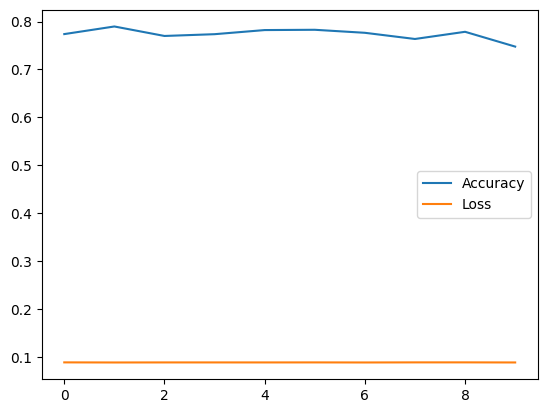

Time for training(Batch Size = 10): 14.524967908859253


In [ ]:
model_10 = Perceptron(output_dim=1)
start = time.time()
model_10.fit(X_Train, Y_Train, epochs = 10, lr = 0.005, batch_size = 10, lambdaReg = 0.01)
end = time.time()
print("Time for training(Batch Size = 10):", (end - start))

#Task 3 Neural Network Classifier

##Weights are initialized using the Xavier initialization using the np.random.randn() function which provides a Gaussian IID for picking random numbers as weights.

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from numpy.linalg import svd

class NeuralNetwork:

  def __init__(self, output_dim, hiddenLayerSize, loss = 'logistic'):
    self.w1 = None
    self.w2 = None
    self.k = hiddenLayerSize
    self.loss_type = loss
    self.output_dim = output_dim
    np.random.seed(42)

  def model(self, x):
    a = np.maximum(0, np.matmul(x, self.w1))
    z = np.clip(np.matmul(a, self.w2), -600, 600)
    return a, np.where(z >= 0, (1/(1 + np.exp(-z))), np.exp(z)/(1 + np.exp(z)))

  def loss(self, Y_batch, Y_pred):
    epsilon = 1e-9
    if self.loss_type == 'quadratic':
      loss = np.mean(0.5 * np.square(Y_batch - Y_pred))
    else:
      loss = -np.mean(Y_batch * np.log(Y_pred + epsilon) + (1 - Y_batch) * np.log(1 - Y_pred + epsilon))
    return loss

  def createBatches(self, data = None, batch_size = 1):
    if data is None:
      return None
    num_batches = data.shape[0] // batch_size
    batches = []
    np.random.shuffle(data)

    for i in range(num_batches):
      mini_batch = data[i * batch_size : (i + 1) * batch_size, :]
      batches.append(mini_batch)

    if data.shape[0] % batch_size != 0:
      remainderBatch = data[(i + 1) * batch_size: , :]
      batches.append(remainderBatch)

    return np.array(batches)

  def predict(self, inp):
        a, P = self.model(inp)
        return (P > 0.5)

  def fit(self, X, Y, epochs = 1, lr = 1, batch_size = 1, lambdaReg = 0.0):
    data = np.concatenate((X, Y), axis = 1)

    #num_classes x num_features shaped weight matrix
    self.w1 = np.random.randn(data.shape[1] - self.output_dim, self.k)
    self.w2 = np.random.randn(self.k, self.output_dim)

    trainAccuracyList = []
    testAccuracyList = []
    max_accuracy = 0
    chkptw1 = None
    chkptw2 = None
    lossList = []

    for epoch in range(epochs):
      mini_batches = self.createBatches(data, batch_size)
      stepLoss = 0
      for mini_batch in mini_batches:
        batch_x = mini_batch[:, :-self.output_dim]
        batch_y = mini_batch[:, -self.output_dim:]
        a, y_pred = self.model(batch_x)

        if self.loss_type == 'quadratic':
            delta2 = y_pred - batch_y
            grad_w2 = np.matmul(a.T, delta2) / batch_size - 2 * lambdaReg * self.w2

            delta1 = np.matmul(delta2, self.w2.T) * (a > 0)
            grad_w1 = np.matmul(batch_x.T, delta1) / batch_size - 2 * lambdaReg * self.w1
        else:
            delta2 = y_pred - batch_y
            grad_w2 = np.matmul(a.T, delta2) / batch_size - 2 * lambdaReg * self.w2

            delta1 = np.matmul(delta2, self.w2.T) * np.where(a * (1 - a) > 0, a * (1 - a), np.where(a > 0, a, 1 - a))
            grad_w1 = np.matmul(batch_x.T, delta1) / batch_size - 2 * lambdaReg * self.w1

        self.w1 -= lr * grad_w1
        self.w2 -= lr * grad_w2
        stepLoss += self.loss(batch_y, y_pred)
      lossList.append(stepLoss / len(mini_batches))

      train_accuracy = accuracy_score(self.predict(X_Train), Y_Train)
      test_accuracy = accuracy_score(self.predict(X_Test), Y_Test)

      trainAccuracyList.append(train_accuracy)
      testAccuracyList.append(test_accuracy)

      if test_accuracy > max_accuracy:
        max_accuracy = test_accuracy
        chkptw1 = self.w1
        chkptw2 = self.w2

    self.w1 = chkptw1
    self.w2 = chkptw2

    print("Maximum Test Accuracy:", max_accuracy)
    plt.plot(trainAccuracyList, label = 'Train Accuracy')
    plt.plot(testAccuracyList, label = 'Test Accuracy')
    plt.plot(lossList, label = 'Loss')
    plt.legend()
    plt.show()

Maximum Test Accuracy: 0.8755


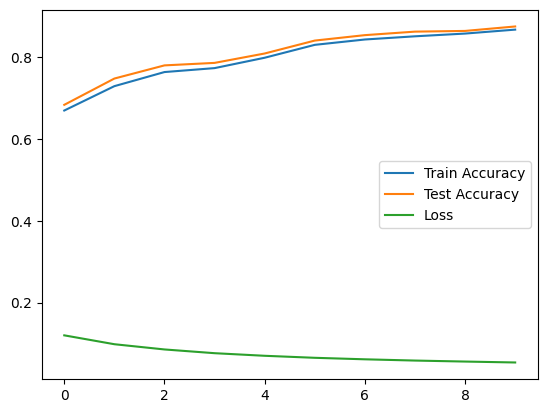

Time for Training with 5 hidden units: 16.464622735977173


In [ ]:
k5 = NeuralNetwork(output_dim=1, hiddenLayerSize=5, loss = 'quadratic')
start = time.time()
k5.fit(X_Train, Y_Train, epochs=10, batch_size=10, lr=0.01)
end = time.time()
print("Time for Training with 5 hidden units:", (end - start))

Maximum Test Accuracy: 0.9428


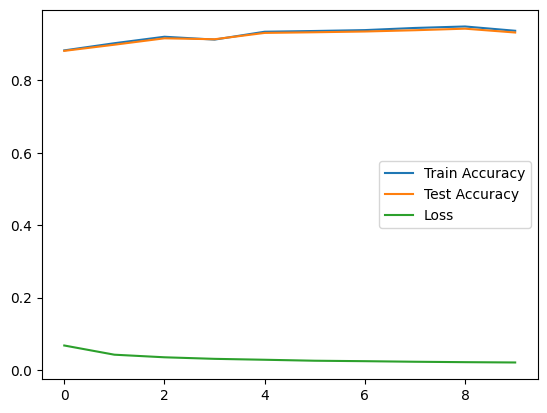

Time for Training with 40 hidden units: 41.40524649620056


In [ ]:
k40 = NeuralNetwork(output_dim=1, hiddenLayerSize=40, loss = 'quadratic')
start = time.time()
k40.fit(X_Train, Y_Train, epochs=10, batch_size=10, lr=0.03)
end = time.time()
print("Time for Training with 40 hidden units:", (end - start))

Maximum Test Accuracy: 0.9571


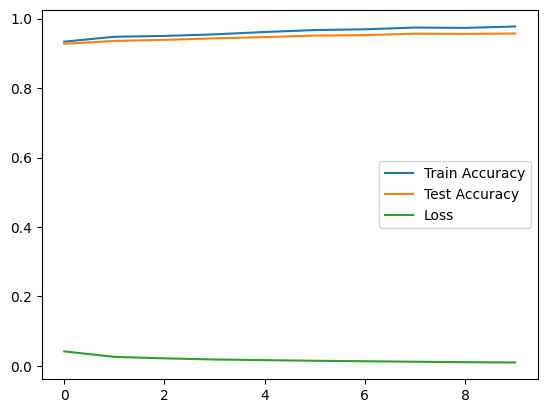

Time for Training with 200 hidden units: 124.3805742263794


In [ ]:
k200 = NeuralNetwork(output_dim=1, hiddenLayerSize=200, loss='quadratic')
start = time.time()
k200.fit(X_Train, Y_Train, epochs=10, batch_size=10, lr=0.05)
end = time.time()
print("Time for Training with 200 hidden units:", (end - start))

#Task 4 Neural Network with Logistic Loss

Maximum Test Accuracy: 0.8338


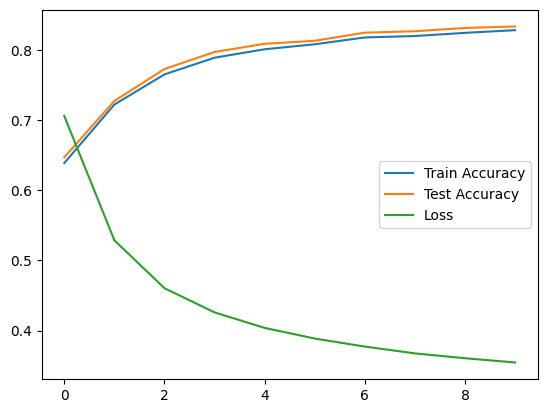

Time for Training with 5 hidden units: 17.246646642684937


In [ ]:
k5 = NeuralNetwork(output_dim=1, hiddenLayerSize=5, loss='logistic')
start = time.time()
k5.fit(X_Train, Y_Train, epochs=10, batch_size=10, lr=0.001)
end = time.time()
print("Time for Training with 5 hidden units:", (end - start))

Maximum Test Accuracy: 0.9387


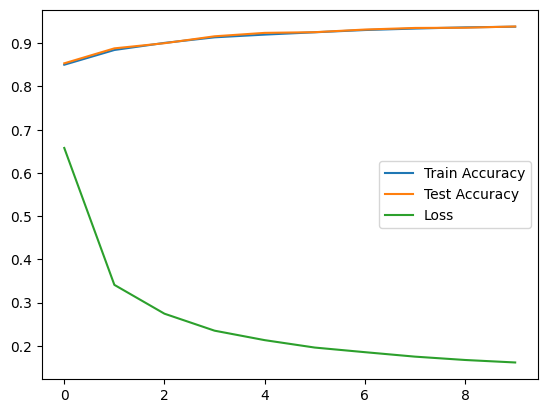

Time for Training with 40 hidden units: 45.99562072753906


In [ ]:
k40 = NeuralNetwork(output_dim=1, hiddenLayerSize=40, loss = 'logistic')
start = time.time()
k40.fit(X_Train, Y_Train, epochs=10, batch_size=10, lr=0.003)
end = time.time()
print("Time for Training with 40 hidden units:", (end - start))

Maximum Test Accuracy: 0.95


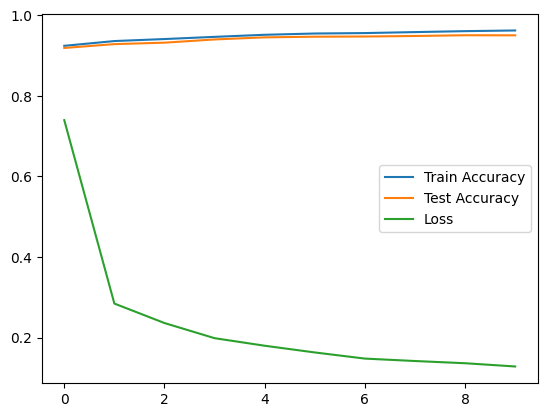

Time for Training with 200 hidden units: 129.86987805366516


In [ ]:
k200 = NeuralNetwork(output_dim=1, hiddenLayerSize=200, loss='logistic')
start = time.time()
k200.fit(X_Train, Y_Train, epochs=10, batch_size=10, lr=0.005)
end = time.time()
print("Time for Training with 200 hidden units:", (end - start))

#Task 6

The linear classifier is less accurate than the Neural Network since the decision boundary of the former is linear whereas the Neural Network uses an approximation of a step function to obtain a non-linear decision boundary, thereby accounting for higher accuracy. It uses a digital approximation of an analog signal, thus allowing the network to estimate any kind of function.

The quadratic loss is a convex optimization surface whereas the logistic loss is a non-convex optimization surface. Thus it is harder to optimize a logistic loss function and gradient. A constant learning rate performs worse on the logistic loss due to the jagged, non-convex shape of the logistic loss function. The constant learning rate also had to be decreased for the logistic loss to perform comparably with the quadratic loss since the Neural Net gets stuck at a local optima with a higher learning rate. The logistic loss is better suited for such a classification task but it requires a momentum based adaptive learning rate in order to outperform the quadratic loss.